In [1]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [2]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k

In [15]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    #snail parameters
    flux = 0.435
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 8
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    #cavity1 parameters
    omega_c1 = 3*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 7*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    index1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    index2 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    bare_diff = (energy[index1] - energy[index2])/2/np.pi
    
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, index1), basis(total_dim, index2)]
    
    
    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    omegac1p = f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, omegac1p , omega/2/np.pi)
    omegac1p = omegac1p + k *omega/2/np.pi
    omegac2p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, omegac2p, omega/2/np.pi)
    omegac2p = omegac2p + k *omega/2/np.pi
    diff = omegac2p - omegac1p
    return diff

In [16]:
energy_diff(0,10)

4.011476224367788

In [17]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def gbs(A,omega):
    #snail parameters
    flux = 0.435
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

    #cavity1 parameters
    omega_c1 = 3*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 7*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    print(g_int2*snail.c2**0.25)
    eta = A/2/snail.phi_zpf/(-omega+snail.omegas)/2
    return eta,eta*6*snail.g3*g_int1*snail.c2**0.25/(snail.omegas - omega_c1)*g_int2*snail.c2**0.25/(-snail.omegas +omega_c2)/2/np.pi

In [18]:
import scipy
def fit_avoided_crossing(energy_diff):

    # define the cost function to fit the avoided crossing
    def cost_func(parameters):
        g = parameters[0]   # beam splitter rate 
        a = parameters[1]   # energy difference between two modes, excluding effects from avoided crossings 
        res = 0
        for i in range(len(omegas)):
            # sometimes it is helpful to select the part of data to fit with 
            # if omega_list[i]/(2*np.pi)<3.95 or omega_list[i]/(2*np.pi) > 3.96:
#             if omegas[i]<0.279:
                delta =   detuning - omegas[i]
                res += np.abs(energy_diff[i] - (a+ np.sign(delta) * np.sqrt(4*g**2 + (delta)**2) - delta ) )**2 
        return res

    # boundaries of the fitting parameters 
    bb = scipy.optimize.Bounds(np.array([0.01e-4, 4.011,]), np.array([1e-3, 4.012,]))
    
    # initial guess 
    x0 = np.array([1e-3, 4.011567357533754])
    
    res = scipy.optimize.minimize(cost_func, x0, bounds=bb, method='Powell', tol=1e-30)
    print(res)
    # store fitted beam splitter rate, unit in MHz
    g = res.x[0]   
    a = res.x[1]
    return g, a,
# Define A values to sample
A_values = np.linspace(0.5, 1.2, 4)*2*np.pi

# List to store results of g for each A
g_values = []

# Main loop to compute required parameters for each A
for A in A_values:
    omegas = np.linspace(4.011 * 2 * np.pi, 4.012 * 2 * np.pi, 20)
    # Parallel computation for each A
    results = Parallel(n_jobs=25)(delayed(energy_diff)(A, omega) for omega in omegas)
    omegas = omegas / (2 * np.pi)
    index_of_min = np.argmin(results)
    index_of_max = np.argmax(results)
    detuning = (omegas[index_of_min] + omegas[index_of_max]) / 2
    g, a = fit_avoided_crossing(results)
    g_values.append(g)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.67808004492979e-10
       x: [ 1.803e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 2.742e-12  2.611e-13]]
    nfev: 133
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.1854387210495693e-10
       x: [ 2.582e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 4.142e-12  4.134e-13]]
    nfev: 126
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.956364825769786e-11
       x: [ 3.296e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 8.245e-13  8.693e-14]]
    nfev: 135
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.7276258629258442e-08
       x: [ 3.614e-04  4.011e+00]
     nit: 5
   direc: [[-2.948e-05 -6.680e-06]
           [-6.227e-09 -4.661e-08]]
    nfev: 321


0.6559525937945636
0.6559525937945636
0.6559525937945636
0.6559525937945636


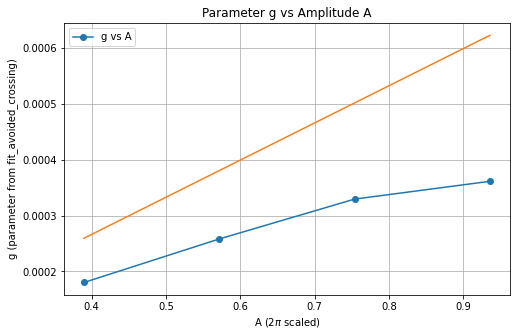

In [21]:
# Parameters
B = 4.012 * 2 * np.pi

# A range of values scaled by 2*pi
A_values = np.linspace(0.5, 1.2, 4)*2*np.pi

# List to store results
results = []
eta = []
# Loop through A values and compute the gbs function
for A in A_values:
    result = gbs(A, B)
    results.append(result[1])
    eta.append(result[0])

plt.figure(figsize=(8, 5))
plt.plot(eta, g_values, 'o-', label='g vs A')
plt.plot(eta, results)
plt.xlabel('A ($2\pi$ scaled)')
plt.ylabel('g (parameter from fit_avoided_crossing)')
plt.title('Parameter g vs Amplitude A')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
g_values

[0.00018034578954785455,
 0.0002582366045493646,
 0.00032958993599217844,
 0.00036144005621927195]

In [13]:
np.array(results)

array([2.59512746e-05, 8.65042487e-05, 1.47057223e-04, 2.07610197e-04])

In [ ]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed
import qutip as qt

In [ ]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    flux = 0.403925
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 200
    N = 3
    dims = 8
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()
    
    
    #cavity1 parameters
    omega_c1 = 5*2*np.pi
    g_int1 = 0.075*2*np.pi
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 4*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()
    
    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)
    
    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy0,U = np.linalg.eigh(H)
#     snailcc = SNAILCC(snail,cavity1,cavity2)
#     H0,Hc = snailcc.hamiltonian()
    
#     energy,U = np.linalg.eigh(H0)

    index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
    index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))
    detuning = energy0[index2]-energy0[index1]
    total_dim = dims*dimc1*dimc2
    H0 = Qobj(H)
    Hc = Qobj(Hc)
    psi0 = qt.basis(total_dim, index1)
    Iss = qt.qeye(dims)
    s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
    cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
    cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
    cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
    PP1 = qt.Qobj(np.array(qt.tensor(Iss, cavity0, cavity1)))
    PP2 = qt.Qobj(np.array(qt.tensor(Iss, cavity1, cavity0)))

    
    T = (2*np.pi)/omega
    omega1 = 4.83 * 2 * np.pi
    A1 = 0.01* 2 * np.pi
    args = {'w': omega,'w1':omega1}
    tlist = np.linspace(0, 50000 * T, 100000)  # Cover ten periods
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)],[Hc, lambda t, args: A1*np.cos(args['w1']*t)]] 
#     options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
    exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])

    return result,exp_P1,exp_P2

In [14]:
A = 0.2 * 2 * np.pi
omega =25.204831869962916
result,exp_P1,exp_P2 = energy_diff(A,omega)

In [15]:
# Range for omega
omega_values = np.linspace(25.204, 25.206, 50)  # Fine grid between the limits

# Parallel computation of exp_P2 for each omega
results = Parallel(n_jobs=-1)(delayed(lambda om: energy_diff(A, om)[2])(om) for om in omega_values)


Traceback (most recent call last):
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, ti

capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-bac

KeyboardInterrupt: 

*kwargs)
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 600, in __call__
    raise WorkerInterrupt() from e
KeyboardInterrupt
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/qutip/sesolve.py", line 136, in sesolve
    res = _generic_ode_solve(func, ode_args, psi0, tlist, e_ops, options,

The above exception was the direct cause of the following exception:

  File "/opt/anaconda3/envs/yunwei/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_985367/942292672.py", line 5, in <lambda>
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/qutip/sesolve.py", line 381, in _generic_ode_solve
    r.integrate(r.t + dt[t_idx])
Traceback (most recent call last):
joblib.my_exceptions.WorkerInterrupt
  File "/tmp/ipykernel_985367/3512182535.py", line 73, in energy_diff
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/externals

  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "qutip/cy/cqobjevo.pyx", line 293, in qutip.cy.cqobjevo.CQobjEvo._factor_dyn
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "qutip/cy/cqobjevo.pyx", line 278, in qutip.cy.cqobjevo.CQobjEvo._factor
  File "/tmp/ipykernel_985367/942292672.py", line 5, in <lambda>
  File "/opt/anaconda3/envs/yunwei/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "qutip/cy/cqobjevo.pyx", line 278, in qutip.cy.cqobjevo.CQobjEvo._factor
  File "/tmp/ipykernel_985367/942292672.py", line 5, in <lambda>
  File "/opt/anaconda3/envs

In [ ]:
results = np.array(results)
omega_values = omega_values /2/np.pi
import matplotlib.pyplot as plt
from matplotlib import cm
T= (2*np.pi)/omega
time_points = tlist = np.linspace(0, 50000 * T, 100000) 
# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plotting the heatmap, transposing the results matrix
heatmap = plt.imshow(results.T, aspect='auto', origin='lower', 
                     extent=[ omega_values.min(), omega_values.max(),time_points.min(), time_points.max()], cmap=cm.viridis)
cbar = plt.colorbar(heatmap)
cbar.set_label('Amplitude (exp_P2)')

# Labeling the axes
plt.ylabel('Time (seconds)')
plt.xlabel('Frequency (omega)')
plt.title('Amplitude (exp_P2) vs. Time and Frequency')

# Show the plot
plt.show()